# Seminar QF: Credit Risk Analysis Pipeline

This notebook implements a comprehensive pipeline for credit risk analysis using various volatility models:
1.  **Merton Model**: To estimate asset values and volatility from equity data.
2.  **GARCH(1,1)**: Single-regime volatility modeling.
3.  **Regime-Switching (Hamilton Filter)**: Volatility modeling with regime changes.
4.  **MS-GARCH**: Optimized Markov-Switching GARCH model.
5.  **Monte Carlo Simulation**: To forecast future asset values.
6.  **CDS Spread Calculation**: Estimating credit default swap spreads based on simulated default probabilities.

### 0. Setup
Initialize the environment, add `src` to the system path, and define configuration.

In [1]:
# Setup
import sys
import os
import shutil
from pathlib import Path
import pandas as pd
import numpy as np

# Add project root to path so we can import src
# Assuming notebook is in notebooks/, project root is parent
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Import config and modules
try:
    from src.utils import config
    from src.data.data_processing import load_and_preprocess_data, run_merton_estimation, load_interest_rates
    from src.models.garch_model import run_garch_estimation
    from src.models.regime_switching import run_regime_switching_estimation
    from src.models.ms_garch_optimized import run_ms_garch_estimation_optimized
    from src.models.probability_of_default import run_pd_pipeline, calculate_merton_pd_normal
    from src.analysis.result_summary import generate_results_summary
    from src.analysis.monte_carlo_garch import monte_carlo_garch_1year_parallel  # Use parallel version
    from src.analysis.volatility_diagnostics import run_volatility_diagnostics, filter_problematic_firms
    from src.analysis.monte_carlo_regime_switching import monte_carlo_regime_switching_1year_parallel  # Use parallel version
    from src.analysis.monte_carlo_ms_garch import monte_carlo_ms_garch_1year_parallel  # Use parallel version
    from src.analysis.cds_spread_calculator import CDSSpreadCalculator
    from src.analysis.cds_correlation import run_cds_correlation_analysis, plot_cds_correlations

    print("Imports successful.")
    print(f"Data Directory: {config.DATA_DIR}")
except ImportError as e:
    print(f"Import Error: {e}")
    # print(f"sys.path: {sys.path}")

Imports successful.
Data Directory: /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data


### 1. Cache Cleanup
Remove intermediate files.

In [2]:
# Cache Cleanup
print("Cleaning up cache files...")
cache_dir = config.INTERMEDIATES_DIR
cache_files = [
    'merton_results_cache.pkl',
    'mc_garch_cache.csv'
]

for cache_file in cache_files:
    cache_path = cache_dir / cache_file
    if cache_path.exists():
        try:
            os.remove(cache_path)
            print(f"✓ Deleted: {cache_path}")
        except Exception as e:
            print(f"⚠ Could not delete {cache_path}: {e}")
    else:
        print(f"  (No cached file: {cache_path})")

print("Cache cleanup complete.")


Cleaning up cache files...
  (No cached file: /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/intermediates/merton_results_cache.pkl)
  (No cached file: /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/intermediates/mc_garch_cache.csv)
Cache cleanup complete.


### 2. Data Loading & Merton Model Estimation
*   **Load Interest Rates**: From ECB data.
*   **Load Equity Data**: From Excel inputs.
*   **Run Merton Model**: Solves for Asset Value ($V_t$) and Asset Volatility ($\sigma_A$) using the iterative approach.
*   **Output**: `merged_data_with_merton.csv` and `daily_asset_returns.csv`.

In [3]:
# Load Interest Rates
interest_rates_df = load_interest_rates()
print(f"Loaded {len(interest_rates_df)} months of interest rate data")

# Load Equity/Liability Data
df = load_and_preprocess_data()

# Run Merton Model
df_merged, daily_returns_df = run_merton_estimation(df, interest_rates_df)

# Save Results
df_merged.to_csv(config.OUTPUT_DIR / "merged_data_with_merton.csv", index=False)
daily_returns_df.to_csv(config.OUTPUT_DIR / "daily_asset_returns.csv", index=False)

print(f"Saved to {config.OUTPUT_DIR}")

Loaded 384 months of interest rate data
Loading equity data...
Removed 21 flagged companies (including 5 financial institutions)
Remaining firms: 29

Filtered out 7337 rows from 2025 (keeping data up to and including 2024)
Loading liability data...
Removed 21 flagged companies (including 5 financial institutions)
Remaining firms: 29

Filtered out 7337 rows from 2025 (keeping data up to and including 2024)
Loading liability data...
Scaled liabilities from millions to actual currency units (×1,000,000)
Merging liabilities using Point-in-Time (fdate) logic...
Loaded liability data

MERTON MODEL ESTIMATION (Vectorized + Parallelized - EXACT ndtr)

Processing 29 firms with -1 parallel jobs...

Starting parallel Merton estimation...
Scaled liabilities from millions to actual currency units (×1,000,000)
Merging liabilities using Point-in-Time (fdate) logic...
Loaded liability data

MERTON MODEL ESTIMATION (Vectorized + Parallelized - EXACT ndtr)

Processing 29 firms with -1 parallel jobs...



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  Firm 5/29 (gvkey=17452): 200/3588 dates
  Firm 1/29 (gvkey=14447): 200/3619 dates
  Firm 6/29 (gvkey=23667): 200/3599 dates
  Firm 4/29 (gvkey=17436): 200/3599 dates
  Firm 2/29 (gvkey=15677): 200/3598 dates
  Firm 7/29 (gvkey=23671): 200/3601 dates
  Firm 8/29 (gvkey=24625): 200/3598 dates
  Firm 3/29 (gvkey=15724): 200/3589 dates
  Firm 1/29 (gvkey=14447): 300/3619 dates
  Firm 6/29 (gvkey=23667): 300/3599 dates
  Firm 5/29 (gvkey=17452): 300/3588 dates
  Firm 4/29 (gvkey=17436): 300/3599 dates
  Firm 8/29 (gvkey=24625): 300/3598 dates
  Firm 2/29 (gvkey=15677): 300/3598 dates
  Firm 7/29 (gvkey=23671): 300/3601 dates
  Firm 1/29 (gvkey=14447): 300/3619 dates
  Firm 6/29 (gvkey=23667): 300/3599 dates
  Firm 5/29 (gvkey=17452): 300/3588 dates
  Firm 4/29 (gvkey=17436): 300/3599 dates
  Firm 8/29 (gvkey=24625): 300/3598 dates
  Firm 2/29 (gvkey=15677): 300/3598 dates
  Firm 7/29 (gvkey=23671): 300/3601 dates
  Firm 3/29 (gvkey=15724): 300/3589 dates
  Firm 5/29 (gvkey=17452): 400/358

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   15.6s


  Firm 4/29 (gvkey=17436): 3500/3599 dates
  Firm 7/29 (gvkey=23671): 3100/3601 dates
  Firm 8/29 (gvkey=24625): 3400/3598 dates
  Firm 3/29 (gvkey=15724): 3100/3589 dates
  Firm 2/29 (gvkey=15677): 3100/3598 dates
  Firm 9/29 (gvkey=61616): 200/3582 dates
  Firm 8/29 (gvkey=24625): 3500/3598 dates
  Firm 7/29 (gvkey=23671): 3200/3601 dates
  Firm 10/29 (gvkey=100022): 200/3597 dates
  Firm 3/29 (gvkey=15724): 3200/3589 dates
  Firm 2/29 (gvkey=15677): 3200/3598 dates
  Firm 9/29 (gvkey=61616): 200/3582 dates
  Firm 8/29 (gvkey=24625): 3500/3598 dates
  Firm 7/29 (gvkey=23671): 3200/3601 dates
  Firm 10/29 (gvkey=100022): 200/3597 dates
  Firm 3/29 (gvkey=15724): 3200/3589 dates
  Firm 2/29 (gvkey=15677): 3200/3598 dates
  Firm 11/29 (gvkey=100080): 200/3607 dates
  Firm 9/29 (gvkey=61616): 300/3582 dates
  Firm 7/29 (gvkey=23671): 3300/3601 dates
  Firm 3/29 (gvkey=15724): 3300/3589 dates
  Firm 2/29 (gvkey=15677): 3300/3598 dates
  Firm 10/29 (gvkey=100022): 300/3597 dates
  Firm 11/

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   27.6s


  Firm 15/29 (gvkey=101204): 3200/3607 dates
  Firm 13/29 (gvkey=100957): 3300/3607 dates
  Firm 16/29 (gvkey=101336): 3100/3617 dates
  Firm 11/29 (gvkey=100080): 3500/3607 dates
  Firm 17/29 (gvkey=101361): 200/3598 dates
  Firm 10/29 (gvkey=100022): 3300/3597 dates
  Firm 9/29 (gvkey=61616): 3500/3582 dates
  Firm 14/29 (gvkey=101202): 3300/3587 dates
  Firm 15/29 (gvkey=101204): 3300/3607 dates
  Firm 13/29 (gvkey=100957): 3400/3607 dates
  Firm 11/29 (gvkey=100080): 3500/3607 dates
  Firm 17/29 (gvkey=101361): 200/3598 dates
  Firm 10/29 (gvkey=100022): 3300/3597 dates
  Firm 9/29 (gvkey=61616): 3500/3582 dates
  Firm 14/29 (gvkey=101202): 3300/3587 dates
  Firm 15/29 (gvkey=101204): 3300/3607 dates
  Firm 13/29 (gvkey=100957): 3400/3607 dates
  Firm 16/29 (gvkey=101336): 3200/3617 dates
  Firm 14/29 (gvkey=101202): 3400/3587 dates
  Firm 15/29 (gvkey=101204): 3400/3607 dates
  Firm 17/29 (gvkey=101361): 300/3598 dates
  Firm 10/29 (gvkey=100022): 3400/3597 dates
  Firm 11/29 (gvk

[Parallel(n_jobs=-1)]: Done  17 out of  29 | elapsed:   39.6s remaining:   28.0s


  Firm 23/29 (gvkey=220940): 2900/3607 dates
  Firm 22/29 (gvkey=220833): 2700/3594 dates
  Firm 18/29 (gvkey=102296): 3100/3587 dates
  Firm 20/29 (gvkey=132740): 3300/3656 dates
  Firm 24/29 (gvkey=221244): 3100/3607 dates
  Firm 19/29 (gvkey=103487): 3500/3595 dates
  Firm 21/29 (gvkey=201794): 2900/3578 dates
  Firm 25/29 (gvkey=221616): 200/3605 dates
  Firm 23/29 (gvkey=220940): 3000/3607 dates
  Firm 22/29 (gvkey=220833): 2800/3594 dates
  Firm 18/29 (gvkey=102296): 3200/3587 dates
  Firm 20/29 (gvkey=132740): 3400/3656 dates
  Firm 24/29 (gvkey=221244): 3200/3607 dates
  Firm 21/29 (gvkey=201794): 2900/3578 dates
  Firm 25/29 (gvkey=221616): 200/3605 dates
  Firm 23/29 (gvkey=220940): 3000/3607 dates
  Firm 22/29 (gvkey=220833): 2800/3594 dates
  Firm 18/29 (gvkey=102296): 3200/3587 dates
  Firm 20/29 (gvkey=132740): 3400/3656 dates
  Firm 24/29 (gvkey=221244): 3200/3607 dates
  Firm 25/29 (gvkey=221616): 300/3605 dates
  Firm 21/29 (gvkey=201794): 3000/3578 dates
  Firm 18/29 

[Parallel(n_jobs=-1)]: Done  20 out of  29 | elapsed:   41.6s remaining:   18.7s


  Firm 26/29 (gvkey=222379): 500/3589 dates
  Firm 27/29 (gvkey=241456): 300/3602 dates
  Firm 25/29 (gvkey=221616): 700/3605 dates
  Firm 22/29 (gvkey=220833): 3300/3594 dates
  Firm 28/29 (gvkey=241637): 200/3602 dates
  Firm 21/29 (gvkey=201794): 3400/3578 dates
  Firm 23/29 (gvkey=220940): 3500/3607 dates
  Firm 29/29 (gvkey=340153): 200/1109 dates
  Firm 26/29 (gvkey=222379): 600/3589 dates
  Firm 27/29 (gvkey=241456): 400/3602 dates
  Firm 29/29 (gvkey=340153): 200/1109 dates
  Firm 26/29 (gvkey=222379): 600/3589 dates
  Firm 27/29 (gvkey=241456): 400/3602 dates
  Firm 25/29 (gvkey=221616): 800/3605 dates
  Firm 22/29 (gvkey=220833): 3400/3594 dates
  Firm 28/29 (gvkey=241637): 300/3602 dates
  Firm 21/29 (gvkey=201794): 3500/3578 dates
  Firm 23/29 (gvkey=220940): 3600/3607 dates
  Firm 26/29 (gvkey=222379): 700/3589 dates
  Firm 29/29 (gvkey=340153): 300/1109 dates
  Firm 25/29 (gvkey=221616): 800/3605 dates
  Firm 22/29 (gvkey=220833): 3400/3594 dates
  Firm 28/29 (gvkey=24163

[Parallel(n_jobs=-1)]: Done  23 out of  29 | elapsed:   42.8s remaining:   11.2s


  Firm 28/29 (gvkey=241637): 500/3602 dates
  Firm 27/29 (gvkey=241456): 600/3602 dates
  Firm 25/29 (gvkey=221616): 1000/3605 dates
  Firm 26/29 (gvkey=222379): 900/3589 dates
  Firm 29/29 (gvkey=340153): 500/1109 dates
  Firm 28/29 (gvkey=241637): 600/3602 dates
  Firm 27/29 (gvkey=241456): 700/3602 dates
  Firm 25/29 (gvkey=221616): 1100/3605 dates
  Firm 26/29 (gvkey=222379): 1000/3589 dates
  Firm 29/29 (gvkey=340153): 500/1109 dates
  Firm 28/29 (gvkey=241637): 600/3602 dates
  Firm 27/29 (gvkey=241456): 700/3602 dates
  Firm 25/29 (gvkey=221616): 1100/3605 dates
  Firm 26/29 (gvkey=222379): 1000/3589 dates
  Firm 27/29 (gvkey=241456): 800/3602 dates
  Firm 28/29 (gvkey=241637): 700/3602 dates
  Firm 29/29 (gvkey=340153): 600/1109 dates
  Firm 26/29 (gvkey=222379): 1100/3589 dates
  Firm 25/29 (gvkey=221616): 1200/3605 dates
  Firm 27/29 (gvkey=241456): 800/3602 dates
  Firm 28/29 (gvkey=241637): 700/3602 dates
  Firm 29/29 (gvkey=340153): 600/1109 dates
  Firm 26/29 (gvkey=22237

[Parallel(n_jobs=-1)]: Done  26 out of  29 | elapsed:   48.9s remaining:    5.6s


  Firm 25/29 (gvkey=221616): 3600/3605 dates
  Firm 27/29 (gvkey=241456): 3400/3602 dates
  Firm 28/29 (gvkey=241637): 3200/3602 dates
  Firm 27/29 (gvkey=241456): 3500/3602 dates
  Firm 28/29 (gvkey=241637): 3300/3602 dates
  Firm 27/29 (gvkey=241456): 3600/3602 dates
  Firm 27/29 (gvkey=241456): 3500/3602 dates
  Firm 28/29 (gvkey=241637): 3300/3602 dates
  Firm 27/29 (gvkey=241456): 3600/3602 dates
  Firm 28/29 (gvkey=241637): 3400/3602 dates
  Firm 28/29 (gvkey=241637): 3500/3602 dates
  Firm 28/29 (gvkey=241637): 3400/3602 dates
  Firm 28/29 (gvkey=241637): 3500/3602 dates
  Firm 28/29 (gvkey=241637): 3600/3602 dates
  Firm 28/29 (gvkey=241637): 3600/3602 dates


[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:   49.9s finished



✓ Parallel Merton complete in 0:00:50

Caching 97,597 Merton results...
✓ Cached to: /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/intermediates/merton_results_cache.pkl

Merton Estimation Complete
Total time: 0:00:50
Firms processed: 29
Daily results: 97,568

Saved to /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/output
Saved to /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/output


### 3. GARCH(1,1) Estimation
Estimates a standard GARCH(1,1) model on the daily asset returns derived from the Merton model.
*   **Input**: `daily_asset_returns.csv`
*   **Output**: `daily_asset_returns_with_garch.csv` (adds conditional volatility columns).

In [4]:
final_daily_returns = run_garch_estimation(daily_returns_df)

# Save Results
final_daily_returns.to_csv(config.OUTPUT_DIR / "daily_asset_returns_with_garch.csv", index=False)
print("Saved 'daily_asset_returns_with_garch.csv'")

Estimating GARCH(1,1) with t-distribution on DAILY Asset Returns...
Processing GARCH for 29 firms (Daily Data)...
Processed GARCH for 10 firms...
Processed GARCH for 10 firms...
Processed GARCH for 20 firms...
Processed GARCH for 20 firms...
GARCH estimation complete.
GARCH estimation complete.
Saved 'daily_asset_returns_with_garch.csv'
Saved 'daily_asset_returns_with_garch.csv'


### 4. Regime-Switching Model (Hamilton Filter)
Estimates a 2-state Markov Switching model on returns (High Volatility / Low Volatility states), independent of GARCH dynamics inside the states.
*   **Output**: `daily_asset_returns_with_regime.csv`.

In [5]:
final_daily_returns_rs = run_regime_switching_estimation(daily_returns_df)

# Save Results
final_daily_returns_rs.to_csv(config.OUTPUT_DIR / "daily_asset_returns_with_regime.csv", index=False)
print("Saved 'daily_asset_returns_with_regime.csv'")

Estimating Regime Switching Model (2-Regime Markov) on DAILY Returns...
(Hamilton Filter)

Processing Regime Switching for 29 firms...

  ✓ Firm 1/29: gvkey=14447
      Observations: 3469
      Regime 0: μ=0.499875, σ=0.008970
      Regime 1: μ=0.499876, σ=0.009516
      Transition: P(0→0)=0.340, P(1→1)=0.650

  ✓ Firm 1/29: gvkey=14447
      Observations: 3469
      Regime 0: μ=0.499875, σ=0.008970
      Regime 1: μ=0.499876, σ=0.009516
      Transition: P(0→0)=0.340, P(1→1)=0.650

  ✓ Firm 2/29: gvkey=15677
      Observations: 3448
      Regime 0: μ=0.499931, σ=0.005243
      Regime 1: μ=0.499935, σ=0.002401
      Transition: P(0→0)=0.175, P(1→1)=0.870

  ✓ Firm 2/29: gvkey=15677
      Observations: 3448
      Regime 0: μ=0.499931, σ=0.005243
      Regime 1: μ=0.499935, σ=0.002401
      Transition: P(0→0)=0.175, P(1→1)=0.870

  ✓ Firm 3/29: gvkey=15724
      Observations: 3439
      Regime 0: μ=0.499839, σ=0.012781
      Regime 1: μ=0.499838, σ=0.003092
      Transition: P(0→0)=0.113

### 5. Optimized MS-GARCH Estimation
Estimates a "True" MS-GARCH model where each regime has its own GARCH(1,1) process.
*   **Optimizations**: Uses Warm Start, JIT Compilation (Numba), and Numerical Optimizations.
*   **Output**: `daily_asset_returns_with_msgarch.csv` and parameter file.

In [6]:
print("Running MS-GARCH Estimation...")
final_daily_returns_msgarch = run_ms_garch_estimation_optimized(
    daily_returns_df,
    output_file=str(config.OUTPUT_DIR / "ms_garch_parameters.csv")
)

# Save Results
final_daily_returns_msgarch.to_csv(config.OUTPUT_DIR / "daily_asset_returns_with_msgarch.csv", index=False)
print("Saved 'daily_asset_returns_with_msgarch.csv'")

Running MS-GARCH Estimation...

OPTIMIZED MS-GARCH ESTIMATION
Optimizations enabled:
  ✓ GARCH(1,1) warm start for initial parameters
  ✓ Numba JIT-compiled Hamilton filter
  ✓ Cached intermediate results
  ✓ L-BFGS-B optimizer with tuned settings

Processing 29 firms...

[1/29] Processing 14447
  Fitting OPTIMIZED MS-GARCH with t-distribution...
    → Getting GARCH(1,1) warm start parameters...
    → Warm start: omega=1.45e-06, alpha=0.036, beta=0.957, nu=4.4
    → Running L-BFGS-B optimization...
  MLE converged: True
  Log-likelihood: 10443.39
  Regime 0 (low vol): omega=0.000001, alpha=0.0352, beta=0.9637, nu=4.54
  Regime 1 (high vol): omega=0.000002, alpha=0.0457, beta=0.9155, nu=4.45
  Persistence: p00=0.9536, p11=0.9522
  MLE converged: True
  Log-likelihood: 10443.39
  Regime 0 (low vol): omega=0.000001, alpha=0.0352, beta=0.9637, nu=4.54
  Regime 1 (high vol): omega=0.000002, alpha=0.0457, beta=0.9155, nu=4.45
  Persistence: p00=0.9536, p11=0.9522
  ✓ Successfully estimated M

### 6. Probability of Default (PD) Calculation
Calculates PD using the Merton Model formula but substituting the volatility estimates from GARCH, RS, and MS-GARCH models.
*   **Benchmark**: Calculates standard Merton PD assuming Normal distribution.
*   **Output**: `daily_pd_results.csv`.

In [7]:
pd_results = run_pd_pipeline(
    str(config.OUTPUT_DIR / 'daily_asset_returns_with_garch.csv'), 
    str(config.OUTPUT_DIR / 'daily_asset_returns_with_regime.csv'), 
    str(config.OUTPUT_DIR / 'daily_asset_returns_with_msgarch.csv')
)

pd_results.to_csv(config.OUTPUT_DIR / "daily_pd_results.csv", index=False)
print("Saved 'daily_pd_results.csv'")

# Merton PD (Benchmark)
merton_normal_pd = calculate_merton_pd_normal(str(config.OUTPUT_DIR / 'daily_asset_returns.csv'))
merton_normal_pd.to_csv(config.OUTPUT_DIR / "daily_pd_results_merton_normal.csv", index=False)
print("Saved 'daily_pd_results_merton_normal.csv'")


PROBABILITY OF DEFAULT CALCULATION (Multi-Model, Daily Data)
Loading auxiliary data (liabilities and interest rates)...
  Loading liabilities...
    ✓ Loaded 741 liability records
  Loading interest rates...
    ✓ Loaded 741 liability records
  Loading interest rates...
    ✓ Loaded 384 months of interest rate data

Calculating PD for each model...

  Processing GARCH...
    ✓ Loaded 384 months of interest rate data

Calculating PD for each model...

  Processing GARCH...
    ✓ GARCH: Calculated PD for 97,568 observations
       PD column name: 'pd_garch'

  Processing Regime Switching...
    ✓ GARCH: Calculated PD for 97,568 observations
       PD column name: 'pd_garch'

  Processing Regime Switching...
    ✓ Loaded regime parameters from regime_switching_parameters.csv
    ✓ Loaded regime parameters from regime_switching_parameters.csv
    ✓ Computed regime-weighted volatility for 97,568 observations
    ✓ Regime Switching: Calculated PD for 97,568 observations
       PD column nam

### 7. Monte Carlo Simulation (GARCH) & Diagnostics
Simulates future asset values for 1 year (252 days) using GARCH volatility dynamics.
Also runs **Volatility Diagnostics** to identify firms with explosive volatility that might distort results.
*   **Output**: `daily_monte_carlo_garch_results.csv` and diagnostic files in `data/diagnostics/`.

In [8]:
print("Run Monte Carlo GARCH (1 year) - PARALLEL with all cores...")
mc_results = monte_carlo_garch_1year_parallel(
    str(config.OUTPUT_DIR / 'daily_asset_returns_with_garch.csv'), 
    gvkey_selected=None, 
    num_simulations=1000,
    num_days=252,
    n_jobs=-1  # Use all available cores
)
mc_results.to_csv(config.OUTPUT_DIR / "daily_monte_carlo_garch_results.csv", index=False)

# Diagnostics
print("Running Volatility Diagnostics...")
diagnostics_results = run_volatility_diagnostics(
    garch_file=str(config.OUTPUT_DIR / 'daily_asset_returns_with_garch.csv'),
    mc_garch_file=str(config.OUTPUT_DIR / 'daily_monte_carlo_garch_results.csv'),
    output_dir=str(config.DIAGNOSTICS_DIR)
)

PROBLEMATIC_FIRMS = diagnostics_results['problematic_firms']
CLEAN_FIRMS = diagnostics_results['clean_firms']
print(f"Problematic Firms: {len(PROBLEMATIC_FIRMS)}")

Run Monte Carlo GARCH (1 year) - PARALLEL with all cores...
Loading GARCH data from /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/output/daily_asset_returns_with_garch.csv...
Running PARALLELIZED Monte Carlo GARCH simulation:
  Firms: 29
  Dates: 3506
  Simulations per firm: 1,000
  Forecast horizon: 252 days
  Parallel jobs: -1
  Innovation distribution: Student's t
Running PARALLELIZED Monte Carlo GARCH simulation:
  Firms: 29
  Dates: 3506
  Simulations per firm: 1,000
  Forecast horizon: 252 days
  Parallel jobs: -1
  Innovation distribution: Student's t

Processing 3506 dates in parallel...

Processing 3506 dates in parallel...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   


PARALLELIZED MONTE CARLO GARCH COMPLETE
Total time: 0:21:07
Rows per second: 77
Speedup: ~-1x expected on -1-core system

Running Volatility Diagnostics...

VOLATILITY DIAGNOSTICS: IDENTIFYING PROBLEMATIC FIRMS

Running Volatility Diagnostics...

VOLATILITY DIAGNOSTICS: IDENTIFYING PROBLEMATIC FIRMS

✓ Loaded GARCH data: 97,568 observations
✓ Number of firms: 29

------------------------------------------------------------
PART 1: GARCH PARAMETER ANALYSIS
------------------------------------------------------------


------------------------------------------------------------
PART 2: MONTE CARLO VOLATILITY ANALYSIS
------------------------------------------------------------

✓ Loaded GARCH data: 97,568 observations
✓ Number of firms: 29

------------------------------------------------------------
PART 1: GARCH PARAMETER ANALYSIS
------------------------------------------------------------


------------------------------------------------------------
PART 2: MONTE CARLO VOLATILITY 

### 8. Monte Carlo Simulation (Regime Switching & MS-GARCH)
Runs MC simulations for the Regime-Switching and MS-GARCH models.
*   **Regime Switching**: Simulates regime changes and draws returns based on state-specific volatility (no GARCH).
*   **MS-GARCH**: Simulates regime changes AND GARCH dynamics within each state.

In [9]:
print("Run MC Regime Switching - PARALLEL with all cores...")
mc_rs_results = monte_carlo_regime_switching_1year_parallel(
    garch_file=str(config.OUTPUT_DIR / 'daily_asset_returns_with_garch.csv'),
    regime_params_file=str(config.OUTPUT_DIR / 'regime_switching_parameters.csv'),
    gvkey_selected=None,
    num_simulations=1000,
    num_days=252,
    n_jobs=-1  # Use all available cores
)
mc_rs_results.to_csv(config.OUTPUT_DIR / "daily_monte_carlo_regime_switching_results.csv", index=False)

print("Run MC MS-GARCH - PARALLEL with all cores...")
mc_msgarch_results = monte_carlo_ms_garch_1year_parallel(
    daily_returns_file=str(config.OUTPUT_DIR / 'daily_asset_returns_with_msgarch.csv'),
    ms_garch_params_file=str(config.OUTPUT_DIR / 'ms_garch_parameters.csv'),
    gvkey_selected=None,
    num_simulations=1000,
    num_days=252,
    n_jobs=-1  # Use all available cores
)
mc_msgarch_results.to_csv(config.OUTPUT_DIR / "daily_monte_carlo_ms_garch_results.csv", index=False)

Run MC Regime Switching - PARALLEL with all cores...

PARALLELIZED MONTE CARLO REGIME-SWITCHING 1-YEAR FORECAST

✓ Loaded regime-switching parameters for 29 firms
✓ Loaded 97,568 observations
  Firms: 29
  Dates: 3506
  Simulations: 1,000
  Horizon: 252 days
  Parallel jobs: -1
✓ Loaded 97,568 observations
  Firms: 29
  Dates: 3506
  Simulations: 1,000
  Horizon: 252 days
  Parallel jobs: -1

Processing 3506 dates in parallel...

Processing 3506 dates in parallel...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   


PARALLELIZED REGIME-SWITCHING MC COMPLETE
Total rows: 97,568
Total time: 0:08:29
Rows per second: 191

Run MC MS-GARCH - PARALLEL with all cores...
Loading daily returns from /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/output/daily_asset_returns_with_msgarch.csv...
Loading MS-GARCH parameters from /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/output/ms_garch_parameters.csv...
Run MC MS-GARCH - PARALLEL with all cores...
Loading daily returns from /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/output/daily_asset_returns_with_msgarch.csv...
Loading MS-GARCH parameters from /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/output/ms_garch_parameters.csv...
Running PARALLELIZED Monte Carlo MS-GARCH simulation:
  Firms: 29
  Dates: 3506
  Simulations per firm: 1,000
  Forecast horizon: 252 days
  Parallel jobs: -1
  Innovation distribution: Student's t per regime
Running PARALLELIZED Monte Carlo MS-GARCH simulation:
  Firms: 29
  Dates: 3506
  S

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   


Regime Fraction Statistics:
  Regime 0 (low vol): mean=0.503
  Regime 1 (high vol): mean=0.497

PARALLELIZED MONTE CARLO MS-GARCH COMPLETE
Total time: 0:23:45
Rows per second: 68
Speedup: ~-1x expected on -1-core system



### 9. CDS Spread Calculation
Calculates Model-Implied CDS Spreads for 1, 3, and 5-year horizons.

**Models:**
1. **Classical Merton (Analytical)**: Uses the asset volatility from the Merton model estimation directly (no Monte Carlo).
2. **GARCH**: Uses Monte Carlo simulated volatility from GARCH(1,1) model.
3. **Regime Switching**: Uses Monte Carlo simulated volatility from the Hamilton Filter RS model.
4. **MS-GARCH**: Uses Monte Carlo simulated volatility from the Markov-Switching GARCH model.

**Output:** Separate CSV files for CDS spreads for each model.

In [ ]:
cds_calc = CDSSpreadCalculator(maturity_horizons=[1, 3, 5])

# Classical Merton (Analytical - no Monte Carlo, uses asset_volatility from Merton estimation)
print("CDS Spreads: Classical Merton (Analytical)")
df_cds_spreads_merton = cds_calc.calculate_cds_spreads_analytical_merton(
    merton_file=str(config.OUTPUT_DIR / 'merged_data_with_merton.csv'),
    output_file=str(config.OUTPUT_DIR / 'cds_spreads_merton_analytical.csv')
)

# GARCH
print("CDS Spreads: GARCH")
df_cds_spreads_garch_all = cds_calc.calculate_cds_spreads_from_mc_garch(
    mc_garch_file=str(config.OUTPUT_DIR / 'daily_monte_carlo_garch_results.csv'),
    daily_returns_file=str(config.OUTPUT_DIR / 'daily_asset_returns.csv'),
    merton_file=str(config.OUTPUT_DIR / 'merged_data_with_merton.csv'),
    output_file=str(config.OUTPUT_DIR / 'cds_spreads_garch_mc_all_firms.csv')
)

# Regime Switching
print("CDS Spreads: RS")
df_cds_spreads_rs_all = cds_calc.calculate_cds_spreads_from_mc_garch(
    mc_garch_file=str(config.OUTPUT_DIR / 'daily_monte_carlo_regime_switching_results.csv'),
    daily_returns_file=str(config.OUTPUT_DIR / 'daily_asset_returns.csv'),
    merton_file=str(config.OUTPUT_DIR / 'merged_data_with_merton.csv'),
    output_file=str(config.OUTPUT_DIR / 'cds_spreads_regime_switching_mc_all_firms.csv')
)

# MS-GARCH
print("CDS Spreads: MS-GARCH")
df_cds_spreads_msgarch_all = cds_calc.calculate_cds_spreads_from_mc_garch(
    mc_garch_file=str(config.OUTPUT_DIR / 'daily_monte_carlo_ms_garch_results.csv'),
    daily_returns_file=str(config.OUTPUT_DIR / 'daily_asset_returns.csv'),
    merton_file=str(config.OUTPUT_DIR / 'merged_data_with_merton.csv'),
    output_file=str(config.OUTPUT_DIR / 'cds_spreads_ms_garch_mc_all_firms.csv'),
    volatility_column='mc_msgarch_cumulative_volatility'
)


CDS Spread Calculator initialized (Section 2.4.2):
  CDS Maturities: [1, 3, 5] years
  Methodology: Malone et al. (2009) - Risk-neutral valuation

CDS Spreads: GARCH

MODEL-IMPLIED CDS SPREADS FROM MONTE CARLO (Section 2.4.2)

Loading data files...

✓ Loaded Monte Carlo results: 97,568 observations
  Columns: ['gvkey', 'date', 'mc_garch_cumulative_volatility', 'mc_garch_mean_daily_volatility', 'mc_garch_std_daily_volatility', 'mc_garch_max_daily_volatility', 'mc_garch_min_daily_volatility', 'mc_garch_p95_daily_volatility', 'mc_garch_p05_daily_volatility']

⚠ Using LEGACY cumulative volatility column (Sum of Sigma).
✓ Using volatility column: 'mc_garch_cumulative_volatility'

✓ Aggregated to 97,568 (gvkey,date) pairs

✓ Loaded daily returns: 97,568 observations
✓ Loaded Monte Carlo results: 97,568 observations
  Columns: ['gvkey', 'date', 'mc_garch_cumulative_volatility', 'mc_garch_mean_daily_volatility', 'mc_garch_std_daily_volatility', 'mc_garch_max_daily_volatility', 'mc_garch_min_d

### 10. Model vs Market CDS Spread Correlation
Compare model-implied CDS spreads with actual market CDS data.
- Loads real CDS data (in basis points) for 1Y, 3Y, and 5Y maturities.
- Matches companies between model and market data.
- Calculates correlations for each firm and overall.

Running CDS Correlation Analysis...
Loading real CDS market data...
  Loaded CDS data: 1Y=166960, 3Y=166960, 5Y=154438 rows
  Loaded CDS data: 1Y=166960, 3Y=166960, 5Y=154438 rows
  Combined market CDS data: 200352 rows
  Combined market CDS data: 200352 rows

=== GARCH Model vs Market CDS ===
  Matched observations: 96609
  Matched companies: 28

  RMSE (Market - Model, in bps):
    1Y: 357.14 bps (n=88771)
    3Y: 195.41 bps (n=88771)
    5Y: 163.63 bps (n=96220)

  Correlation of LEVELS:
    1Y: 0.0587 (n=88771)
    3Y: 0.1714 (n=88771)
    5Y: 0.2011 (n=96220)

  Correlation of CHANGES (Innovations) - Byström (2006):
    1Y: -0.0093 (n=88745)
    3Y: 0.0026 (n=88745)
    5Y: -0.0104 (n=96192)

=== GARCH Model vs Market CDS ===
  Matched observations: 96609
  Matched companies: 28

  RMSE (Market - Model, in bps):
    1Y: 357.14 bps (n=88771)
    3Y: 195.41 bps (n=88771)
    5Y: 163.63 bps (n=96220)

  Correlation of LEVELS:
    1Y: 0.0587 (n=88771)
    3Y: 0.1714 (n=88771)
    5Y: 

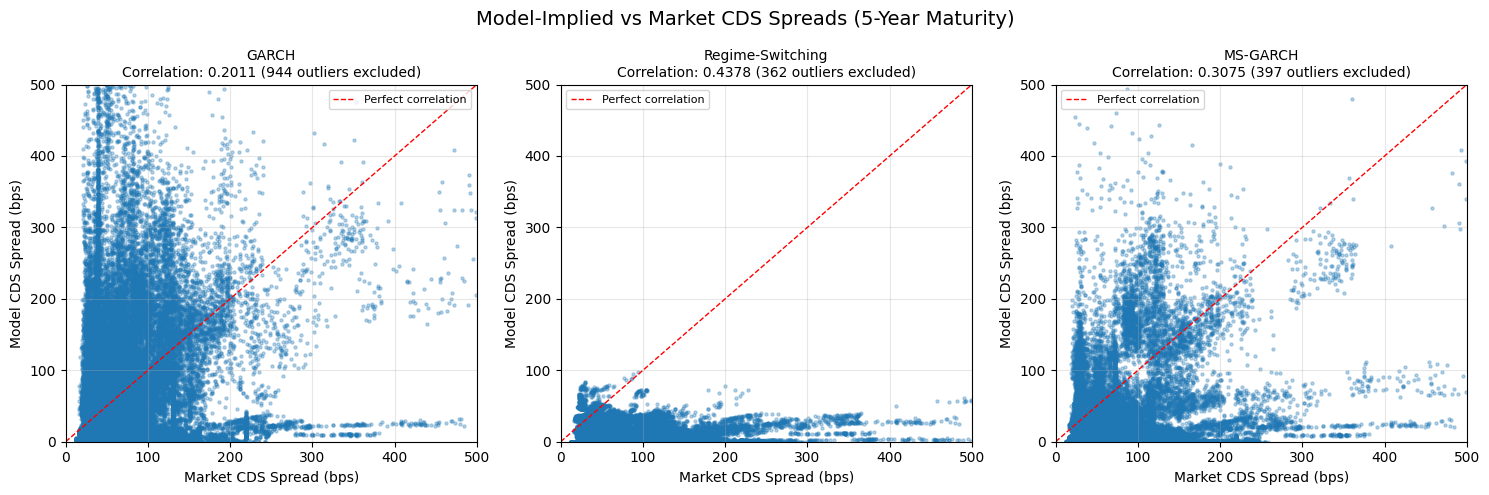

Saved scatter plot to /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/output/cds_model_vs_market_scatter_5y.png


In [11]:
# Reload the module to pick up changes
import importlib
from src.analysis import cds_correlation
importlib.reload(cds_correlation)
from src.analysis.cds_correlation import run_cds_correlation_analysis, plot_cds_correlations

# Run CDS Correlation Analysis
print("Running CDS Correlation Analysis...")
correlation_results = run_cds_correlation_analysis()

# Plot scatter plots (5-year maturity)
# Use axis_limit=500 to zoom in on reasonable CDS spread ranges and exclude extreme outliers
# This makes the visualization clearer without affecting correlation calculations
plot_cds_correlations(correlation_results, maturity=5, axis_limit=500)